In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn.mixture import GaussianMixture

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import jax
import jax.numpy as jnp
from jax import jit, vmap
from jax.nn import sigmoid

import time

In [2]:
# jax.devices()

In [3]:
EPS = 1e-10
fontsize=13

In [4]:
import sys
sys.path.append('../')
import adaprobe

# Vary number of stimuli

In [5]:
test_Ns = [2, 4, 8, 16, 32, 64]
test_num_targets = [1, 2, 4, 8, 16, 32, 64]
test_Ks = [4000]
test_sigmas = [1]
# test_Ks = [500, 1000, 2000, 4000]
# test_sigmas = [1, 3, 5]

In [6]:
# fit_options = {
#     'iters': 100,
#     'num_mc_samples': 20,
#     'seed': 1
# }

fit_options_wo_alpha = {
    'iters': 100,
    'num_mc_samples': 50,
    'seed': 0,
    'penalty': 1e-1,
    'learn_alpha': False
}

In [9]:
# # sigma = 1
# # K = 500
powers = np.arange(10, 51, 10)
a = 0.2
num_repeats = 5


for sigma in test_sigmas:
    for K in test_Ks:

        error_matrix = -1 * np.ones((len(test_Ns), len(test_num_targets), num_repeats))

        tstart = time.time()
        for idxn, N in enumerate(test_Ns):
            for idxs, num_targets in enumerate(test_num_targets):
                if num_targets > N:
                    continue
                for rep in range(num_repeats):
                    print('pop size: %i,  num_targets: %i,  run: %i\t'%(N, num_targets, rep), end='\r')

                    # generate simulation
                    phi_1 = np.random.uniform(2.5, 5.5, N)
                    sim = adaprobe.Simulation3d(N=N, phi_1=phi_1, a=a, sigma=sigma)
                    sim.simulate_multistim(trials=K, num_targets=np.min([num_targets, N]), powers=powers)

                    # configure priors
                    phi_prior = np.c_[0.1 * np.ones(N), 5 * np.ones(N)]
                    phi_cov_prior = np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])
#                     beta_prior = 7e0 * np.ones(N)
#                     mu_prior = np.zeros(N)
                    
                    priors_without_alpha = {
                        'alpha': np.ones(N), # 0.05
                        'beta': 1e1 * np.ones(N),
                        'mu': np.zeros(N),
                        'phi': phi_prior,
                        'phi_cov': phi_cov_prior
                    }
                    
                    stimulus_matrix = np.zeros((N, K))
                    for n in range(N):
                        locs = np.where(sim.tars == n)[0]
                        stimulus_matrix[n, locs] = sim.I[locs]

                    model = adaprobe.Model(sim.cell_locs, priors=priors_without_alpha)
                    model.fit(sim.y, stimulus_matrix, fit_options=fit_options_wo_alpha, method='cavi_offline_spike_and_slab_NOTS_jax')

                    error_matrix[idxn, idxs, rep] = np.mean(np.abs(sim.w - model.state['mu'] * model.state['alpha']))
        tend = time.time()
#         np.save('multispot_mapping_error_matrix_K%i_sigma%.1f_spike_target_relaxed.npy'%(K, sigma), error_matrix)
        print('\nTotal elapsed time %.2f min'%((tend-tstart)/60))

/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9055.565557518115, tolerance: 8426.738407141149
  model = cd_fast.enet_coordinate_descent(
/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23605.780520664644, tolerance: 8426.738407141149
  model = cd_fast.enet_coordinate_descent(
/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27733.34445201268, tolerance: 8426.738407141149
  model = cd_fast.enet_coordinate_descent(
/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-pa

/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5285.661787947989, tolerance: 4052.2256020111317
  model = cd_fast.enet_coordinate_descent(


/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4748.42623686319, tolerance: 4576.659751116276
  model = cd_fast.enet_coordinate_descent(
/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10384.28566464322, tolerance: 4576.659751116276
  model = cd_fast.enet_coordinate_descent(
/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17280.37627244211, tolerance: 4576.659751116276
  model = cd_fast.enet_coordinate_descent(
/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-pack

/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3675.904241199605, tolerance: 2351.3230331152695
  model = cd_fast.enet_coordinate_descent(
/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3492.6687190892117, tolerance: 2351.3230331152695
  model = cd_fast.enet_coordinate_descent(
/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3630.661420789431, tolerance: 2351.3230331152695
  model = cd_fast.enet_coordinate_descent(
/home/mat2245/anaconda3/envs/jax/lib/python3.9/site

/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2183.294611847028, tolerance: 1914.0041525415347
  model = cd_fast.enet_coordinate_descent(
/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17202.024417357345, tolerance: 1914.0041525415347
  model = cd_fast.enet_coordinate_descent(
/home/mat2245/anaconda3/envs/jax/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2271.202639437455, tolerance: 1914.0041525415347
  model = cd_fast.enet_coordinate_descent(



Total elapsed time 21.49 min


In [10]:
fontsize=13

In [11]:
# for sigma in test_sigmas:
#     for K in test_Ks:
#         error_matrix = np.load('results/multispot_mapping_error_matrix_K%i_sigma%.1f.npy'%(K, sigma))
#         means = np.mean(error_matrix, axis=-1)
#         sdevs = np.std(error_matrix, axis=-1)
        
#         plt.figure(figsize=(12, 4))
#         for N in range(len(test_Ns)):
#             num_pts = len(np.where(means[N] > -1)[0])
#             plt.plot(test_num_targets[:num_pts], means[N][:num_pts], 'o-', color='C%i'%N)
#         #     plt.fill_between(num_targets_all[:num_pts], means[N][:num_pts] - sdevs[N][:num_pts], means[N][:num_pts] + sdevs[N][:num_pts], facecolor='C%i'%N, edgecolor='None', alpha=0.2)
#         plt.xticks(test_num_targets)
#         plt.legend(test_Ns, frameon=False, title='Population size', fontsize=fontsize, title_fontsize=fontsize)
#         plt.ylabel('Mean absolute error\n$|\mathbb{E}[w_n] - w_n|$', fontsize=fontsize)
#         plt.xlabel('Number of simultaneous holograms', fontsize=fontsize)
#         plt.title('Noise: $\sigma$=%.1f\nNumber of trials: K=%i'%(sigma, K))
#         plt.grid(linestyle='--', alpha=0.5)
#         plt.xticks(fontsize=fontsize)
#         plt.yticks(fontsize=fontsize)
#         plt.ylim([-0.25, 10.75])

#         plt.savefig('figs/multi_spot_mapping_offline_err_vs_nstim_sigma%.1f_K%i.png'%(sigma, K), format='png', bbox_inches='tight', dpi=200, facecolor='white')
#         plt.show()
        

In [12]:
means = np.mean(error_matrix, axis=-1)
sdevs = np.std(error_matrix, axis=-1)

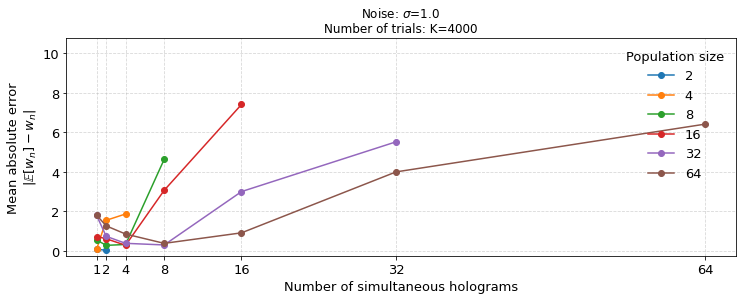

In [15]:
plt.figure(figsize=(12, 4))
for N in range(len(test_Ns)):
    num_pts = len(np.where(means[N] > -1)[0])
    plt.plot(test_num_targets[:num_pts], means[N][:num_pts], 'o-', color='C%i'%N)
#     plt.fill_between(num_targets_all[:num_pts], means[N][:num_pts] - sdevs[N][:num_pts], means[N][:num_pts] + sdevs[N][:num_pts], facecolor='C%i'%N, edgecolor='None', alpha=0.2)
plt.xticks(test_num_targets)
plt.legend(test_Ns, frameon=False, title='Population size', fontsize=fontsize, title_fontsize=fontsize)
plt.ylabel('Mean absolute error\n$|\mathbb{E}[w_n] - w_n|$', fontsize=fontsize)
plt.xlabel('Number of simultaneous holograms', fontsize=fontsize)
plt.title('Noise: $\sigma$=%.1f\nNumber of trials: K=%i'%(sigma, K))
plt.grid(linestyle='--', alpha=0.5)
# for loc in ['top', 'right']:
#     plt.gca().spines[loc].set_visible(False)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim([-0.25, 10.75])

# plt.savefig('figs/model_based_cs/multi_spot_mapping_offline_err_vs_nstim_hybrid_mbcs_sigma%.1f_K%i.png'%(sigma, K), format='png', bbox_inches='tight', dpi=200, facecolor='white')
plt.show()